In [1]:
import numpy as np
import matplotlib.pyplot as plt
# low level library compared to cvxpy
from cvxopt import matrix, solvers


Quadratic optimization problems
1. Linear Hard Margin SVM
2. Linear Soft Margin SVM with slack variable and regularization parameter C
3. Nonlinear SVM with Kernel

Optimization Problem into the Primal form is 
$$
\begin{aligned}
\text{Minimize: } & \frac{1}{2} |w|^2 \
\text{Subject to: } & y_i (w^T x_i + b) \geq 1, \quad \forall i
\end{aligned}
$$

Lagrange Multipliers Method for Dual
$$
L(w,b,\alpha) = \frac{1}{2}|w|^2 - \sum_{i=1}^{m}\alpha_i y_i(w^T x_i + b) - 1$$

where $(\alpha_i \geq 0)$ are **Lagrange multipliers**.
It's dual form will be 
Objective function 
$$
\max_{\alpha} \sum_i \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j x_i^T x_j
$$
subject to
$$
\alpha_i \ge 0, \ \sum_i \alpha_i y_i = 0
$$

In [3]:
class LinearHardMarginSVM:
    def __init__(self):
        self.w = None
        self.b = None
        self.support_vectors = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = y.astype(float)

        # Compute the Gram matrix
        K = np.dot(X, X.T)

        # Define the QP parameters for cvxopt
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G = matrix(-np.eye(n_samples))
        h = matrix(np.zeros(n_samples))
        A = matrix(y, (1, n_samples))
        b = matrix(0.0)

        # Solve QP
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)

        alphas = np.ravel(sol['x'])

        # Support vectors have non zero lagrange multipliers
        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.support_vectors = X[sv]
        self.support_y = y[sv]

        # Compute weight vector and bias
        self.w = np.sum(self.alphas[:, None] * self.support_y[:, None] * self.support_vectors, axis=0)
        self.b = np.mean(self.support_y - np.dot(self.support_vectors, self.w))

    def project(self, X):
        return np.dot(X, self.w) + self.b

    def predict(self, X):
        return np.sign(self.project(X))


In [5]:
class LinearSoftMarginSVM(LinearHardMarginSVM):
    def __init__(self, C=1.0):
        super().__init__()
        self.C = C

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = y.astype(float)
        K = np.dot(X, X.T)

        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = matrix(y, (1, n_samples))
        b = matrix(0.0)

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(sol['x'])

        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.support_vectors = X[sv]
        self.support_y = y[sv]

        self.w = np.sum(self.alphas[:, None] * self.support_y[:, None] * self.support_vectors, axis=0)
        self.b = np.mean(self.support_y - np.dot(self.support_vectors, self.w))


In [6]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x1, x2, p=3):
    return (1 + np.dot(x1, x2)) ** p

def rbf_kernel(x1, x2, gamma=0.5):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

In [ ]:
class NonlinearKernelSVM:
    def __init__(self, C=1.0, kernel=rbf_kernel):
        self.C = C
        self.kernel = kernel

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = y.astype(float)

        # Compute Kernel matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])

        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = matrix(y, (1, n_samples))
        b = matrix(0.0)

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(sol['x'])

        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y[sv]

        # Compute bias term b
        self.b = np.mean([
            y_k - np.sum(self.alphas * self.sv_y * np.array([self.kernel(x_k, x_i) for x_i in self.sv_X]))
            for x_k, y_k in zip(self.sv_X, self.sv_y)
        ])

    def project(self, X):
        y_predict = np.zeros(len(X))
        for i, x in enumerate(X):
            s = 0
            for alpha, sv_y, sv_x in zip(self.alphas, self.sv_y, self.sv_X):
                s += alpha * sv_y * self.kernel(x, sv_x)
            y_predict[i] = s
        return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

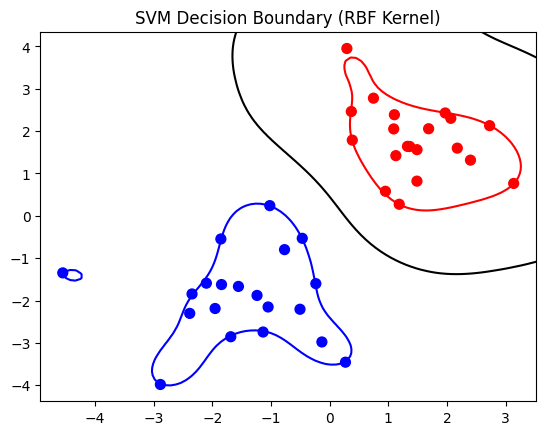

In [ ]:
# Generate toy data
np.random.seed(0)
X1 = np.random.randn(20, 2) - [2, 2]
X2 = np.random.randn(20, 2) + [2, 2]
X = np.vstack((X1, X2))
y = np.hstack((-1 * np.ones(20), +1 * np.ones(20)))

# Train and visualize
svm = NonlinearKernelSVM(C=1.0, kernel=rbf_kernel)
svm.fit(X, y)

# Plot
def plot_contour(X, y, model):
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=50)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                         np.linspace(ylim[0], ylim[1], 100))
    XY = np.vstack([xx.ravel(), yy.ravel()]).T
    Z = model.project(XY).reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'])
    plt.title("SVM Decision Boundary (RBF Kernel)")
    plt.show()

plot_contour(X, y, svm)